# **Quick Draw: Catch Doodle!**

“Quick, Draw!” is a game created by Google. It's a game where one player is prompted to draw a picture of an object, and the other player needs to guess what it is. More details can be found [this post](https://towardsdatascience.com/quick-draw-the-worlds-largest-doodle-dataset-823c22ffce6b). 

This project is for building an image classifier model that can handle noisy and sometimes incomplete drawings and perform well on classifying 50 different animals. This notebook is basically worked with the Kernel on kaggle

Table of contents:
- [1. Load data](# 1. Load data)
- [2. Let's draw doodle](# 2. Let's draw doodle)
- [3. From strokes to Image](# 3. From strokes to Image)
- [4. Let's call all friends here!](# 4. Let's call all friends here!)
- [5. Modeling- CNN](# 5. Modeling- CNN)
- [6. Plot the result](# 6. Plot the result)
- [7. Modeling with ResNet50](# 7. Modeling with ResNet50)

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook')

np.random.seed(36)

In [3]:
import ast
import cv2
import dask.bag as db

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau 

from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19

Using TensorFlow backend.


# 1. Load data <a></a>

I'm going to use only the train_simplified.zip file for training. And we will use only the animal drawings among them. Cause...they are soooo cute :-) To load all 50 animals files automatically, I'll make a list for filenames. 

In [4]:
# list of animals 
animals = ['ant', 'bat', 'bear', 'bee', 'bird', 'butterfly', 'camel', 'cat', 'cow',
           'crab', 'crocodile', 'dog', 'dolphin', 'dragon', 'duck', 'elephant', 'fish',
           'flamingo', 'frog', 'giraffe', 'hedgehog', 'horse', 'kangaroo', 'lion',
           'lobster', 'monkey', 'mosquito', 'mouse', 'octopus', 'owl', 'panda',
           'parrot', 'penguin', 'pig', 'rabbit', 'raccoon', 'rhinoceros', 'scorpion',
           'sea turtle', 'shark', 'sheep', 'snail', 'snake', 'spider', 'squirrel',
           'swan', 'teddy-bear', 'tiger', 'whale', 'zebra']

Before uploading all the files at once, let's take a test with .csv first.

In [5]:
dir_path = '../input/train_simplified/'
df = pd.read_csv(dir_path + animals[0] + '.csv')
df.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[27, 17, 16, 21, 34, 50, 49, 34, 23, 17], [4...",5421013154136064,True,2017-03-27 00:14:57.310330,ant
1,US,"[[[27, 0, 7, 40, 47, 20], [0, 41, 74, 73, 41, ...",4836123148812288,True,2017-03-06 20:00:22.521560,ant
2,US,"[[[34, 18, 14, 4, 1, 2, 10, 18, 46, 69, 83, 89...",5720952853757952,True,2017-01-23 19:53:28.354530,ant
3,US,"[[[59, 33, 16, 10, 61, 71, 69], [33, 36, 46, 5...",6345979559149568,True,2017-03-14 14:52:27.521410,ant
4,US,"[[[17, 16, 19], [140, 167, 177]], [[81, 82, 87...",4704383923126272,True,2017-01-25 21:48:31.256400,ant


`drawing` is the stroke values, which is telling the drawing of animals. We need to exchage this data into image data later. `word` indicates the result of drawings or animals. `recognized` means whether the drawing was understood as a certain object or not. Let's take only the 10 rows per animals and filter the unrecogizable drawing out. 

In [6]:
am = pd.DataFrame(columns = df.columns)

for i in range(len(animals)):
    filename = dir_path + animals[i] + '.csv'
    df = pd.read_csv(filename, nrows = 100)
    df = df[df.recognized == True]
    am = am.append(df)

In [7]:
# Check
am.word.nunique()

50

# 2. Let's draw doodle <a></a>

Before data proprocessing and modeling, let's see how people drew animals. The image information can be found at `drawing` but in order to make it visual, we need some steps of processing. Let's take only 100 data for an example.

In [8]:
# Sampling only 100 examples
ex = am.sample(100)
ex.head()

,countrycode,drawing,key_id,recognized,timestamp,word
12,JP,"[[[48, 0, 4, 52, 76, 61, 57, 60, 75, 83, 147, ...",5343063008346112,True,2017-01-24 08:00:40.819360,flamingo
92,US,"[[[3, 24, 109, 150, 166, 172, 184, 201, 251, 2...",5620091448197120,True,2017-03-08 14:25:49.303200,snail
24,PH,"[[[36, 36], [7, 7]], [[36, 38, 0, 3, 17, 31], ...",5710658249162752,True,2017-03-04 06:56:40.354640,swan
72,UA,"[[[152, 149, 142, 123, 112, 103, 106, 97, 89, ...",6029772519899136,True,2017-01-01 17:50:02.839860,kangaroo
94,GB,"[[[82, 82, 72, 59, 41, 13, 0, 39, 54, 56, 64, ...",5550962590613504,True,2017-03-17 19:34:05.923690,swan


In [9]:
ex.drawing.head(1).values   # -> strings

array(['[[[48, 0, 4, 52, 76, 61, 57, 60, 75, 83, 147, 161, 157, 146, 126, 78, 57], [41, 96, 100, 105, 96, 78, 57, 38, 15, 8, 0, 16, 43, 62, 76, 88, 89]], [[95, 85, 84, 151, 197, 225, 219, 158, 132, 98, 74, 68, 66, 74, 85, 94, 115], [77, 99, 155, 136, 133, 135, 144, 182, 189, 190, 185, 180, 171, 151, 137, 133, 130]], [[109, 100], [189, 236]], [[141, 137], [184, 248]], [[170, 159, 153], [188, 215, 245]], [[193, 189], [181, 255]], [[101, 89, 86, 99, 104, 72, 74, 78, 90, 99, 103, 105], [49, 34, 55, 35, 18, 43, 39, 39, 49, 42, 33, 36]], [[86, 99, 111, 141, 142, 127, 88, 152, 178, 215, 213, 199, 179, 166, 141, 204], [163, 144, 132, 112, 118, 133, 157, 129, 125, 105, 111, 127, 143, 152, 161, 145]], [[192, 213, 200, 143, 129, 138, 148, 154, 156], [163, 166, 179, 189, 189, 186, 187, 192, 203]]]'],
      dtype=object)

Take a note at the front of the result. 
<br>
array(**[ ' [[ 34, 41  ... ]]]) **
<br>
This indicates this data is strings, not list.

In [10]:
ex.drawing.head(1).map(ast.literal_eval).values   # -> list

array([list([[[48, 0, 4, 52, 76, 61, 57, 60, 75, 83, 147, 161, 157, 146, 126, 78, 57], [41, 96, 100, 105, 96, 78, 57, 38, 15, 8, 0, 16, 43, 62, 76, 88, 89]], [[95, 85, 84, 151, 197, 225, 219, 158, 132, 98, 74, 68, 66, 74, 85, 94, 115], [77, 99, 155, 136, 133, 135, 144, 182, 189, 190, 185, 180, 171, 151, 137, 133, 130]], [[109, 100], [189, 236]], [[141, 137], [184, 248]], [[170, 159, 153], [188, 215, 245]], [[193, 189], [181, 255]], [[101, 89, 86, 99, 104, 72, 74, 78, 90, 99, 103, 105], [49, 34, 55, 35, 18, 43, 39, 39, 49, 42, 33, 36]], [[86, 99, 111, 141, 142, 127, 88, 152, 178, 215, 213, 199, 179, 166, 141, 204], [163, 144, 132, 112, 118, 133, 157, 129, 125, 105, 111, 127, 143, 152, 161, 145]], [[192, 213, 200, 143, 129, 138, 148, 154, 156], [163, 166, 179, 189, 189, 186, 187, 192, 203]]])],
      dtype=object)

We can see that the dypes changed. Now we are able to use it for plotting the strokes. Let's convert the other data as well.

In [11]:
# Convert to list
ex['drawing'] = ex.drawing.map(ast.literal_eval)

Now we are going to meet our lovely cats, dogs and pandas. Take a look at the code below.

In [12]:
# Plot the strokes 
# fig, axs = plt.subplots(nrows = 10, ncols = 10, figsize = (10, 8))

# for index, col in enumerate(ex.drawing):
#     ax = axs[index//10, index%10]
#     for x, y in col:
#         ax.plot(x,-np.array(y), lw = 3)
#     ax.axis('off')
    
# plt.show()

The concept of visualization can be seen complex at the first sight but it's not true. First we will get 100 grids and put the drawing in the grids one by one. `enumerate()` will return the index and column values. Let's take one example to understand step by step. 

In [13]:
# Understanding enumerate
for index, col in enumerate(ex.drawing[:12]):
    print('The index is ', index)
    print('Position will be ({}, {})'.format(index//10, index%10))
    print('The strokes are ', col)
    print('===========')

The index is  0
Position will be (0, 0)
The strokes are  [[[48, 0, 4, 52, 76, 61, 57, 60, 75, 83, 147, 161, 157, 146, 126, 78, 57], [41, 96, 100, 105, 96, 78, 57, 38, 15, 8, 0, 16, 43, 62, 76, 88, 89]], [[95, 85, 84, 151, 197, 225, 219, 158, 132, 98, 74, 68, 66, 74, 85, 94, 115], [77, 99, 155, 136, 133, 135, 144, 182, 189, 190, 185, 180, 171, 151, 137, 133, 130]], [[109, 100], [189, 236]], [[141, 137], [184, 248]], [[170, 159, 153], [188, 215, 245]], [[193, 189], [181, 255]], [[101, 89, 86, 99, 104, 72, 74, 78, 90, 99, 103, 105], [49, 34, 55, 35, 18, 43, 39, 39, 49, 42, 33, 36]], [[86, 99, 111, 141, 142, 127, 88, 152, 178, 215, 213, 199, 179, 166, 141, 204], [163, 144, 132, 112, 118, 133, 157, 129, 125, 105, 111, 127, 143, 152, 161, 145]], [[192, 213, 200, 143, 129, 138, 148, 154, 156], [163, 166, 179, 189, 189, 186, 187, 192, 203]]]
The index is  1
Position will be (0, 1)
The strokes are  [[[3, 24, 109, 150, 166, 172, 184, 201, 251, 255, 250, 233, 217, 190, 160, 154, 142, 139, 119, 50

As you can see above `enumerate()` brings us the index and the values one by one. So we are going to plot the values at the given values by col. 

In [14]:
for index, col in enumerate(ex.drawing[:2]):
    print('==================================')
    for x, y in col:
        print('X is {}'.format(x))
        print('Y is {}'.format(y))
        print('-----------------------')

X is [48, 0, 4, 52, 76, 61, 57, 60, 75, 83, 147, 161, 157, 146, 126, 78, 57]
Y is [41, 96, 100, 105, 96, 78, 57, 38, 15, 8, 0, 16, 43, 62, 76, 88, 89]
-----------------------
X is [95, 85, 84, 151, 197, 225, 219, 158, 132, 98, 74, 68, 66, 74, 85, 94, 115]
Y is [77, 99, 155, 136, 133, 135, 144, 182, 189, 190, 185, 180, 171, 151, 137, 133, 130]
-----------------------
X is [109, 100]
Y is [189, 236]
-----------------------
X is [141, 137]
Y is [184, 248]
-----------------------
X is [170, 159, 153]
Y is [188, 215, 245]
-----------------------
X is [193, 189]
Y is [181, 255]
-----------------------
X is [101, 89, 86, 99, 104, 72, 74, 78, 90, 99, 103, 105]
Y is [49, 34, 55, 35, 18, 43, 39, 39, 49, 42, 33, 36]
-----------------------
X is [86, 99, 111, 141, 142, 127, 88, 152, 178, 215, 213, 199, 179, 166, 141, 204]
Y is [163, 144, 132, 112, 118, 133, 157, 129, 125, 105, 111, 127, 143, 152, 161, 145]
-----------------------
X is [192, 213, 200, 143, 129, 138, 148, 154, 156]
Y is [163, 166, 1

So what we are going to do is ploting these x, y values just like what we've been doing with graphs. Now let's apply all this into one shot and finally meet our lovely friends.

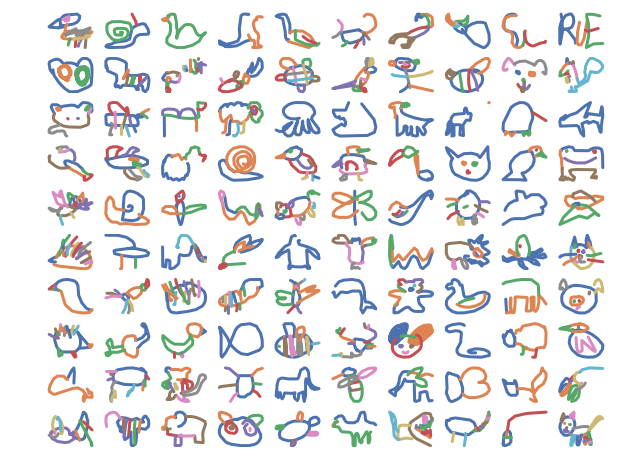

In [15]:
# Plot the strokes 
fig, axs = plt.subplots(nrows = 10, ncols = 10, figsize = (10, 8))

for index, col in enumerate(ex.drawing):
    ax = axs[index//10, index%10]
    for x, y in col:
        ax.plot(x,-np.array(y), lw = 3)
    ax.axis('off')
    
plt.show()

OMG 🙉🙈😍.....This is so funny.

# 3. From strokes to Image <a></a>

Now the next step is transforming all these drawings into image data. Like I said above, the data isn't in the form of image data. We have to covert it into numpy array format. I'm going to make a function for this. 

In [16]:
im_size = 64
n_class = len(animals)

In [17]:
# define a function converting drawing to image data
def draw_to_img(strokes, im_size = im_size):

    fig, ax = plt.subplots()                        # plot the drawing as we did above
    for x, y in strokes:
        ax.plot(x, -np.array(y), lw = 10)
    ax.axis('off')
    
    fig.canvas.draw()                               # update a figure that has been altered
    A = np.array(fig.canvas.renderer._renderer)     # converting them into array
    
    plt.close('all')
    plt.clf()
    
    A = (cv2.resize(A, (im_size, im_size)) / 255.)  # image resizing to uniform format
    
    return A

All the things we discussed at the second section are put inside the `draw_to_img()` function.  Let's try it with an example.

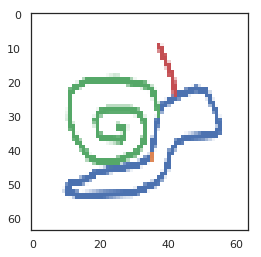

In [18]:
X = ex.drawing.values
image = draw_to_img(X[1])
plt.imshow(image)

In [19]:
image.shape

(64, 64, 4)

The image has 4 channels and we can also check each channels separately.

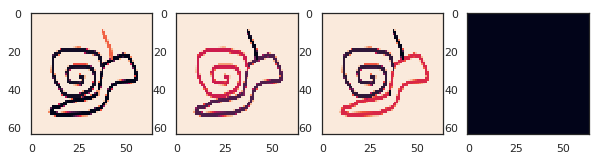

In [20]:
# Channel selection 
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (10, 10))

for i in range(4):
    ax = axs[i]
    ax.imshow(image[:, :, i])

We will make the input image shape as `(im_size, im_size, 3)`, which means it has only one channels. Therefore we''ll take only the last channel here.

In [21]:
# redefine
def draw_to_img(strokes, im_size = im_size):
    fig, ax = plt.subplots()                        # plot the drawing as we did above
    for x, y in strokes:
        ax.plot(x, -np.array(y), lw = 10)
    ax.axis('off')
    
    fig.canvas.draw()                               # update a figure that has been altered
    A = np.array(fig.canvas.renderer._renderer)     # converting them into array
    
    plt.close('all')
    plt.clf()
    
    A = (cv2.resize(A, (im_size, im_size)) / 255.)  # image resizing to uniform format

    return A[:, :, :3]                               # drop the last one 

(64, 64, 3)


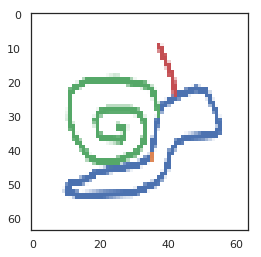

In [22]:
image = draw_to_img(X[1])
plt.imshow(image)
print(image.shape)

# 4. Let's call all friends here! <a></a>

Now we are ready to apply what we've been doing so far into the entire dataset.

In [ ]:
n_samples = 1000
X_train = np.zeros((1, im_size, im_size, 3))
y = []

for a in animals:
    print(a)
    filename = dir_path + a + '.csv'
    df = pd.read_csv(filename, usecols=['drawing', 'word'], nrows=n_samples)  # import the data in chunks
    df['drawing'] = df.drawing.map(ast.literal_eval)                          # convert strings into list
    X = df.drawing.values
    
    img_bag = db.from_sequence(X).map(draw_to_img)                            # covert strokes into array
    X = np.array(img_bag.compute())  
    X_train = np.vstack((X_train, X))                                         # concatenate to get X_train  
    
    y.append(df.word)

ant
bat
bear
bee
bird
butterfly
camel
cat
cow
crab
crocodile
dog
dolphin
dragon
duck
elephant
fish
flamingo
frog
giraffe
hedgehog
horse
kangaroo
lion
lobster
monkey
mosquito
mouse
octopus
owl
panda
parrot
penguin
pig
rabbit
raccoon
rhinoceros
scorpion
sea turtle
shark
sheep
snail
snake
spider
squirrel
swan


As I just stack the array, the dimension of `X_train` has one more values than it's expected. Therefore we'll drop the first layer.  

In [ ]:
# The dimension of X_train
X_train.shape

In [ ]:
# Drop the first layer
X_train = X_train[1:, :, :, :]
X_train.shape

Don't forget to encoding the categorical data before modeling fitting

In [ ]:
# Encoding 
y = pd.DataFrame(y)
y = pd.get_dummies(y)
y_train = np.array(y).transpose()

In [ ]:
# Check the result
print("The input shape is {}".format(X_train.shape))
print("The output shape is {}".format(y_train.shape))

Now let's combine the X_train and y_train again. This is for splitting the data into the trainning set and validation set.  

In [ ]:
# Reshape X_train
X_train_2 = X_train.reshape((X_train.shape[0], im_size*im_size, 3))

# Concatenate X_train and y_train
X_y_train = np.hstack((X_train_2, y_train))

![resize](https://github.com/jjone36/Doodle/blob/master/resize.png)

In [ ]:
# Random shuffle
np.random.shuffle(X_y_train)
a = im_size*im_size
cut = int(len(X_y_train) * .1)
X_val = X_y_train[:cut, :a]
y_val = X_y_train[:cut, a:]
X_train = X_y_train[cut:, :a]
y_train = X_y_train[cut:, a:]

# Reshape X_train back to (64, 64)
X_train = X_train.reshape((X_train.shape[0], im_size, im_size, 1))
X_val = X_val.reshape((X_val.shape[0], im_size, im_size, 1))

Check the final shape of train and validation set.

In [ ]:
# Check the result
print("The input shape of train set is {}".format(X_train.shape))
print("The input shape of validation set is {}".format(X_val.shape))
print("The output shape of train set is {}".format(y_train.shape))
print("The output shape of validation set is {}".format(y_val.shape))

# 5. Modeling- CNN <a></a>

I'm going to start with the basic CNN model as a baseline. And then compare the results with ResNet and VGG19

In [ ]:
n_epochs = 5
batch_size = 500

# Initialize
model = Sequential()

# ConvNet_1
model.add(Conv2D(32, kernel_size = 3, input_shape = (im_size, im_size, 1), padding = 'same', activation = 'relu'))
model.add(MaxPool2D(2, strides = 2))

# ConvNet_2
model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(2, strides = 2))

# Dropout
model.add(Dropout(.2))

# Flattening
model.add(Flatten())

# Fully connected
model.add(Dense(680, activation = 'relu'))

# Dropout
model.add(Dropout(.5))

# Final layer
model.add(Dense(n_class, activation = 'softmax'))

# Compile
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

I'll also add callbacks not to get overfitting. 

In [ ]:
# Early stopper
stopper = EarlyStopping(monitor='val_top_3_accuracy', mode='max', patience = 3)

# Learning rate reducer
reducer = ReduceLROnPlateau(monitor = 'val_acc',
                           patience = 3,
                           verbose = 1,
                           factor = .5,
                           min_lr = 0.00001)

callbacks = [stopper, reducer]

In [ ]:
# Fitting baseline
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = batch_size, 
                    validation_split = .2, verbose = True)

# 6. Plot the result <a></a>

Let's see how well our model is trained.

In [ ]:
# Train and validation curves
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color = 'b', label = 'Train Loss')
ax1.plot(history.history['val_loss'], color = 'm', label = 'Valid Loss')
ax1.legend(loc = 'best')

ax2.plot(history.history['acc'], color = 'b', label = 'Train Accuracy')
ax2.plot(history.history['val_acc'], color = 'm', label = 'Valid Accuracy')
ax2.legend(loc = 'best')

# 7. Modeling with ResNet50

It's seem not good. Let's try other pre-trained model.

In [ ]:
# ResNet50 Application 
model_r = ResNet50(include_top = True, weights= 'imagenet', input_shape=(im_size, im_size, 3), classes = n_class)

In [ ]:
model_r.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_r.summary()

In [ ]:
n_epochs = 5
batch_size = 500

In [ ]:
# Fitting ResNet50
history_r = model_r.fit(X_train, y_train, epochs = n_epochs, batch_size = batch_size, 
                      validation_split = .2, verbose = True)

In [ ]:
# Train and validation curves with ResNet50
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history_r.history['loss'], color = 'b', label = 'Train Loss')
ax1.plot(history_r.history['val_loss'], color = 'm', label = 'Valid Loss')
ax1.legend(loc = 'best')

ax2.plot(history_r.history['acc'], color = 'b', label = 'Train Accuracy')
ax2.plot(history_r.history['val_acc'], color = 'm', label = 'Valid Accuracy')
ax2.legend(loc = 'best')